<a href="https://colab.research.google.com/github/NarciSource/Aivle--MiniProject-4-2/blob/master/2.%20%EB%AC%B8%EC%9D%98%20%EB%82%B4%EC%9A%A9%20%EC%9C%A0%ED%98%95%20%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EC%97%90%EC%9D%B4%EB%B8%94%EB%9F%AC_jbk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn wordcloud python-mecab-ko wget transformers

### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget,os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import wget,os

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### 1-3. 한글 글꼴 설정

In [ ]:
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 전처리한 데이터 불러오기
* 1, 2일차에 전처리한 데이터를 불러옵니다.
* sparse data에 대해서는 scipy.sparse.load_npz 활용

In [ ]:
from scipy.sparse import load_npz
x_train_tfidf = load_npz('/content/drive/MyDrive/aivle/mp4_2/x_train_tfidf.npz')
x_test_tfidf = load_npz('/content/drive/MyDrive/aivle/mp4_2/x_test_tfidf.npz')
x_train_e_tfidf = load_npz('/content/drive/MyDrive/aivle/mp4_2/x_train_e_tfidf.npz')
x_test_e_tfidf = load_npz('/content/drive/MyDrive/aivle/mp4_2/x_test_e_tfidf.npz')
y_train = pd.read_csv('/content/drive/MyDrive/aivle/mp4_2/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/aivle/mp4_2/y_test.csv')
y_train_e = pd.read_csv('/content/drive/MyDrive/aivle/mp4_2/y_train_e.csv')

x_train_s = load_npz('/content/drive/MyDrive/aivle/mp4_2/x_train_s.npz').toarray()
x_test_s = load_npz('/content/drive/MyDrive/aivle/mp4_2/x_test_s.npz').toarray()

w2v_train_test = np.load('/content/drive/MyDrive/aivle/mp4_2/w2v_train_test.npz')
df_shape = pd.DataFrame(data={'tfidf': [x_train_tfidf.shape, x_test_tfidf.shape, y_train.shape, y_test.shape],
                              'tfidf_e': [x_train_e_tfidf.shape, x_test_e_tfidf.shape, y_train_e.shape, y_test.shape],
                        'sequence': [x_train_s.shape, x_test_s.shape, y_train.shape, y_test.shape],
                    },
                  index=['x_train','x_test','y_train','y_test'])
df_shape.T

,x_train,x_test,y_train,y_test
tfidf,"(2594, 67408)","(1112, 67408)","(2594, 1)","(1112, 1)"
tfidf_e,"(10463, 98681)","(1112, 98681)","(10463, 1)","(1112, 1)"
sequence,"(2594, 8)","(1112, 8)","(2594, 1)","(1112, 1)"


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import RandomizedSearchCV

In [ ]:
results = {'TFIDF': {}, 'Sequence': {}, 'Word2Vec': {}}

### ML

In [ ]:
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_mlp = MLPClassifier(learning_rate_init=0.0001,
                        max_iter = 300,activation = 'relu',
                        solver = 'adam',verbose= True)
model_ada = AdaBoostClassifier()
model_gpc = GaussianProcessClassifier()
model_gnb = GaussianNB()
model_qda = QuadraticDiscriminantAnalysis()
model_sgd = SGDClassifier()

def ml(x_train, y_train, x_test, y_test):
    results = {}

    model_lr.fit(x_train, y_train)
    results['RL'] = model_lr.score(x_test, y_test)
    print('RL', results['RL'])

    model_dt.fit(x_train, y_train)
    results['DT'] = model_dt.score(x_test, y_test)
    print('DT', results['DT'])

    model_rf.fit(x_train, y_train)
    results['RF'] = model_rf.score(x_test, y_test)
    print('RF', results['RF'])

    model_mlp.fit(x_train, y_train)
    results['MLP'] = model_mlp.score(x_test, y_test)
    print('MLP', results['MLP'])

    model_sgd.fit(x_train, y_train)
    results['SGD'] = model_sgd.score(x_test, y_test)
    print('SGD', results['SGD'])
    """
    model_ada.fit(x_train, y_train)
    results['AdaBoost'] = model_ada.score(x_test, y_test)
    print('AdaBoost', results['AdaBoost'])

    model_gpc.fit(x_train.toarray(), y_train)
    results['GaussianProcess'] = model_gpc.score(x_test.toarray(), y_test)
    print('GaussianProcess', results['GaussianProcess'])

    model_gnb.fit(x_train, y_train)
    results['GaussianNB'] = model_gnb.score(x_test, y_test)
    print('GaussianNB', results['GaussianNB'])
    model_qda.fit(x_train.toarray(), y_train)
    results['QuadraticDiscriminant'] = model_qda.score(x_test.toarray(), y_test)
    print('QuadraticDiscriminant', results['QuadraticDiscriminant'])
    """
    return results, [model_lr, model_dt, model_rf, model_mlp, model_sgd]

### DNN

In [ ]:
def dnn(x_train, y_train, x_test, y_test):
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    tf.keras.backend.clear_session()

    il = tf.keras.layers.Input(shape=x_train.shape[1:])

    hl = tf.keras.layers.Dense(8, activation='relu')(il)
    hl = tf.keras.layers.Dropout(0.8)(hl)
    hl = tf.keras.layers.BatchNormalization()(hl)
    ol = tf.keras.layers.Dense(5, activation='softmax')(hl)

    model = tf.keras.Model(il, ol)
    model.summary()

    model.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy,
                     metrics=['accuracy'],
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=2, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=100000, verbose=1,
                        batch_size=16,
                        validation_split=0.2,
                        callbacks=[earlyStopping])

    sns.lineplot(history.history['loss'], label='train loss')
    sns.lineplot(history.history['val_loss'], label='val loss')
    plt.show()
    loss, acc = model.evaluate(x_test, y_test)
    print("Accuracy: ", acc)
    y_pred = np.argmax(model.predict(x_test), axis=1)
    print(classification_report(y_test, y_pred))
    return acc, model

### RNN

In [ ]:
def rnn(x_train, y_train, x_test, y_test):
    x_train = np.array(x_train).reshape((*x_train.shape, 1))
    x_test = np.array(x_test).reshape((*x_test.shape, 1))

    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


    tf.keras.backend.clear_session()

    il = tf.keras.layers.Input(shape=x_train.shape[1:])

    hl = tf.keras.layers.Dropout(.4)(il)
    hl = tf.keras.layers.LSTM(4, return_sequences=True)(hl)

    hl = tf.keras.layers.Flatten()(hl)

    hl = tf.keras.layers.Dropout(.4)(hl)
    hl = tf.keras.layers.Dense(16, activation='relu')(hl)
    hl = tf.keras.layers.Dropout(.4)(hl)
    ol = tf.keras.layers.Dense(5, activation='softmax')(hl)

    model_dl = tf.keras.Model(il, ol)
    model_dl.summary()

    model_dl.compile(loss=tf.keras.metrics.categorical_crossentropy,
          metrics=['accuracy'], optimizer='adam')

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, restore_best_weights=True)

    history = model_dl.fit(x_train, y_train, epochs=1000, verbose=1,
                           batch_size = 32,
                            validation_split=0.2,
                            callbacks=[earlyStopping])

    sns.lineplot(history.history['loss'], label='train loss')
    sns.lineplot(history.history['val_loss'], label='val loss')
    plt.show()
    loss, acc = model_dl.evaluate(x_test, y_test)
    print("Accuracy: ", acc)
    return acc, model_dl

### CNN


In [ ]:
def cnn(x_train, y_train, x_test, y_test):
    x_train = np.array(x_train).reshape((*x_train.shape, 1))
    x_test = np.array(x_test).reshape((*x_test.shape, 1))

    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


    tf.keras.backend.clear_session()

    il = tf.keras.layers.Input(shape=x_train.shape[1:])

    hl = tf.keras.layers.Dropout(.4)(il)
    hl = tf.keras.layers.Conv1D(filters=10,
                           kernel_size=3,
                           padding='same',
                           activation='relu')(hl)
    hl = tf.keras.layers.MaxPool1D(pool_size=3, padding='same')(hl)

    hl = tf.keras.layers.Flatten()(hl)
    hl = tf.keras.layers.Dropout(.4)(hl)
    hl = tf.keras.layers.Dense(16, activation='relu')(hl)
    hl = tf.keras.layers.Dropout(.4)(hl)
    ol = tf.keras.layers.Dense(5, activation='softmax')(hl)

    model_dl = tf.keras.Model(il, ol)
    model_dl.summary()

    model_dl.compile(loss=tf.keras.metrics.categorical_crossentropy,
          metrics=['accuracy'], optimizer='adam')

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, restore_best_weights=True)

    history = model_dl.fit(x_train, y_train, epochs=1000, verbose=1,
                           batch_size = 32,
                            validation_split=0.2,
                            callbacks=[earlyStopping])

    sns.lineplot(history.history['loss'], label='train loss')
    sns.lineplot(history.history['val_loss'], label='val loss')
    plt.show()
    loss, acc = model_dl.evaluate(x_test, y_test)
    print("Accuracy: ", acc)
    return acc, model_dl

## 3. Machine Learning(N-grams)
* N-gram으로 전처리한 데이터를 이용하여 3개 이상의 Machine Learning 모델 학습 및 성능 분석
> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

### 3-1. ML

In [ ]:
results['TFIDF'] = ml(x_train_tfidf, y_train, x_test_tfidf, y_test)

RL 0.829136690647482
DT 0.6133093525179856
RF 0.7517985611510791
MLP 0.8552158273381295
SGD 0.8426258992805755


In [ ]:
results['TFIDF'], model_result = ml(x_train_tfidf, y_train, x_test_tfidf, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RL 0.8075539568345323
DT 0.6564748201438849


<ipython-input-22-53fbd339a5b2>:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(x_train, y_train)


RF 0.7473021582733813


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.60699418
Iteration 2, loss = 1.59035323
Iteration 3, loss = 1.57259792
Iteration 4, loss = 1.55110337
Iteration 5, loss = 1.52624978
Iteration 6, loss = 1.49904034
Iteration 7, loss = 1.47027292
Iteration 8, loss = 1.44026009
Iteration 9, loss = 1.40945811
Iteration 10, loss = 1.37801669
Iteration 11, loss = 1.34617028
Iteration 12, loss = 1.31404341
Iteration 13, loss = 1.28177150
Iteration 14, loss = 1.24936010
Iteration 15, loss = 1.21705726
Iteration 16, loss = 1.18484396
Iteration 17, loss = 1.15266060
Iteration 18, loss = 1.12064004
Iteration 19, loss = 1.08902093
Iteration 20, loss = 1.05744120
Iteration 21, loss = 1.02638780
Iteration 22, loss = 0.99572624
Iteration 23, loss = 0.96544420
Iteration 24, loss = 0.93586832
Iteration 25, loss = 0.90669237
Iteration 26, loss = 0.87809219
Iteration 27, loss = 0.85027616
Iteration 28, loss = 0.82291009
Iteration 29, loss = 0.79629836
Iteration 30, loss = 0.77039794
Iteration 31, loss = 0.74515731
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
results['TFIDF'], model_result = ml(x_train_e_tfidf, y_train_e, x_test_e_tfidf, y_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'C':  np.logspace(0, 4, num=10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
random_search = RandomizedSearchCV(model_lr, param_grid, cv=5)
random_search.fit(x_train_e_tfidf, y_train_e)

best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_e_tfidf)

In [ ]:
best_model.score(x_test_e_tfidf, y_test)

### 3-2. DNN

(2594, 67408) (2594, 1) (1112, 67408) (1112, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 67408)]           0         
                                                                 
 dense (Dense)               (None, 8)                 539272    
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 batch_normalization (Batch  (None, 8)                 32        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 539349 (2.06 MB)
Trainable params: 539333 (2.06 MB)
Non-trainable

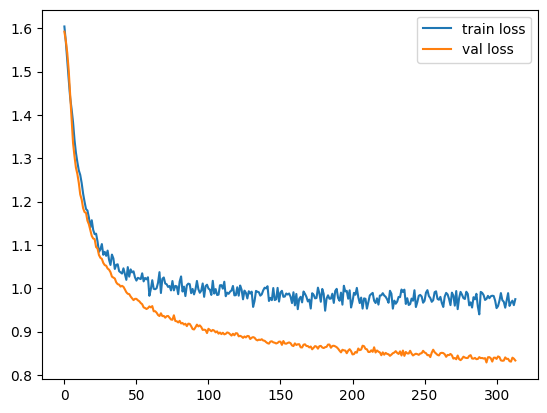

35/35 [==============================] - 0s 9ms/step - loss: 0.7676 - accuracy: 0.7635
Accuracy:  0.7634891867637634
35/35 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.73      0.92      0.82       473
           1       0.95      0.62      0.75       220
           2       0.64      0.76      0.69       219
           3       0.96      0.64      0.77       174
           4       0.00      0.00      0.00        26

    accuracy                           0.76      1112
   macro avg       0.66      0.59      0.61      1112
weighted avg       0.78      0.76      0.75      1112



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acc, model_tfidf_dnn = dnn(x_train_tfidf.todense(), y_train, x_test_tfidf.todense(), y_test)
results['TFIDF']['DNN'] = acc

In [ ]:
acc, model_tfidf_e_dnn = dnn(x_train_e_tfidf.todense(), y_train_e, x_test_e_tfidf.todense(), y_test)
results['TFIDF_e']['DNN'] = acc

### 3-3. Model 3

In [ ]:
#acc, model_tfidf_rnn = rnn(x_train_tfidf.todense(), y_train, x_test_tfidf.todense(), y_test)
#results['TFIDF']['RNN'] = acc

### 3-4. Hyperparameter Tuning(Optional)
* Manual Search, Grid search, Bayesian Optimization, TPE...
> * [grid search tutorial sklearn](https://scikit-learn.org/stable/modules/grid_search.html)
> * [optuna tutorial](https://optuna.org/#code_examples)
> * [ray-tune tutorial](https://docs.ray.io/en/latest/tune/examples/tune-sklearn.html)

In [ ]:
param = {
    'max_iter' : range(100, 500),
    'warm_start' : [True, False],
    'solver' : ['lbfgs', 'newton-cg', 'liblinear'],
    'C' : np.arange(0, 1, 0.01),
}

model_lr_tuning = RandomizedSearchCV(
    model_lr,
    param_distributions=param, # 파라미터 입력
    n_iter = 10,
    cv = 5,
    scoring='accuracy',
    verbose=1,
)

model_lr_tuning.fit(x_train_tfidf, y_train)

In [ ]:
model_lr_tuning.score(x_test_tfidf, y_test)

## 4. Deep Learning(Sequence)
* Sequence로 전처리한 데이터를 이용하여 DNN, 1-D CNN, LSTM 등 3가지 이상의 deep learning 모델 학습 및 성능 분석
> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)

In [ ]:
x_train_s.shape

(2594, 8)

In [ ]:
results['Sequence'] = ml(x_train_s, y_train, x_test_s, y_test)

### 4-1. DNN

(2594, 8) (2594, 1) (1112, 8) (1112, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 batch_normalization (Batch  (None, 8)                 32        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 149 (596.00 Byte)
Trainable params: 133 (532.00 Byte)
Non-trainable param

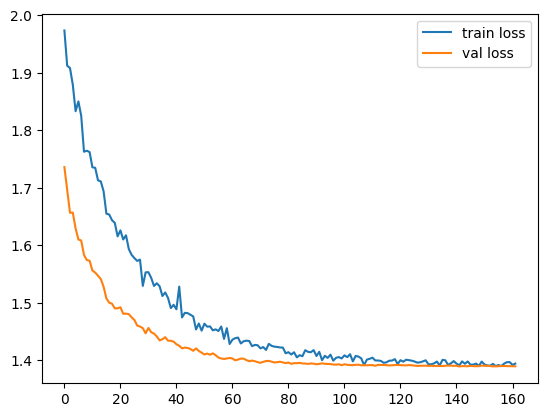

35/35 [==============================] - 0s 3ms/step - loss: 1.3858 - accuracy: 0.4254
Accuracy:  0.42535972595214844
35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       473
           1       0.00      0.00      0.00       220
           2       0.00      0.00      0.00       219
           3       0.00      0.00      0.00       174
           4       0.00      0.00      0.00        26

    accuracy                           0.43      1112
   macro avg       0.09      0.20      0.12      1112
weighted avg       0.18      0.43      0.25      1112



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acc, model_sequence_dnn = dnn(x_train_s, y_train, x_test_s, y_test)
results['Sequence']['DNN'] = acc

### 4-2. 1-D CNN

(2594, 8, 1) (2594, 5) (1112, 8, 1) (1112, 5)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 1)]            0         
                                                                 
 dropout (Dropout)           (None, 8, 1)              0         
                                                                 
 conv1d (Conv1D)             (None, 8, 10)             40        
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 10)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
               

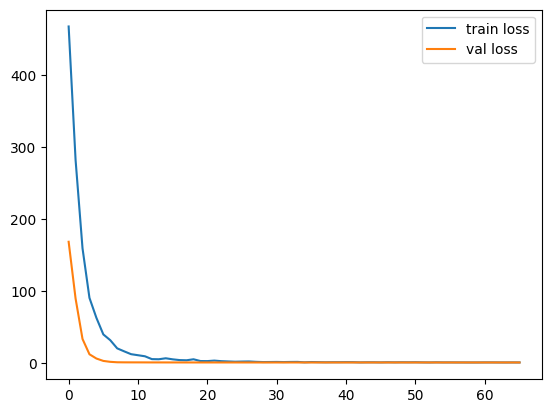

35/35 [==============================] - 0s 3ms/step - loss: 1.3840 - accuracy: 0.4254
Accuracy:  0.42535972595214844


In [ ]:
acc, model_sequence_cnn = cnn(x_train_s, y_train, x_test_s, y_test)
results['Sequence']['CNN'] = acc

### 4-3. LSTM

(2594, 8, 1) (2594, 5) (1112, 8, 1) (1112, 5)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 1)]            0         
                                                                 
 dropout (Dropout)           (None, 8, 1)              0         
                                                                 
 lstm (LSTM)                 (None, 8, 4)              96        
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_2 (Dro

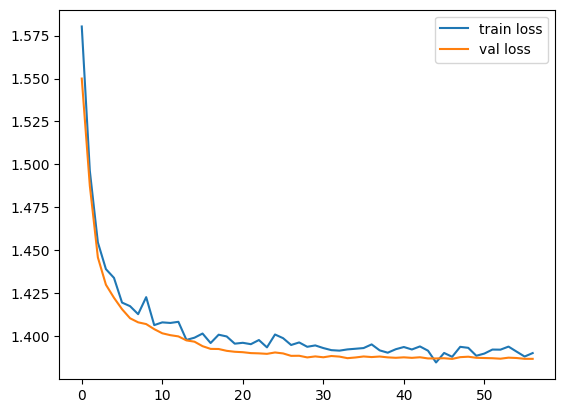

35/35 [==============================] - 0s 5ms/step - loss: 1.3838 - accuracy: 0.4254
Accuracy:  0.42535972595214844


In [ ]:
acc, model_sequence_rnn = rnn(x_train_s, y_train, x_test_s, y_test)
results['Sequence']['RNN'] = acc

## Word2Vec

### 5-1. ML

In [ ]:
results['Word2Vec'] = ml(x_train_w2v, y_train_w2v, x_test_w2v, y_test_w2v)

### 5-2. DNN

In [ ]:
print(x_train_w2v.shape, y_train_w2v.shape, x_test_w2v.shape, y_test_w2v.shape)

In [ ]:
acc, model_word2vec_dnn = dnn(x_train_w2v, y_train_w2v, x_test_w2v, y_test_w2v)
results['Word2Vec']['DNN'] = acc

### 5-3. RNN

In [ ]:
acc, model_word2vec_rnn = rnn(x_train_w2v, y_train_w2v, x_test_w2v, y_test_w2v)
results['Word2Vec']['RNN'] = acc

### 5-4. CNN


In [ ]:
acc, model_word2vec_cnn = cnn(x_train_w2v, y_train_w2v, x_test_w2v, y_test_w2v)
results['Word2Vec']['CNN'] = acc

## 모델 비교

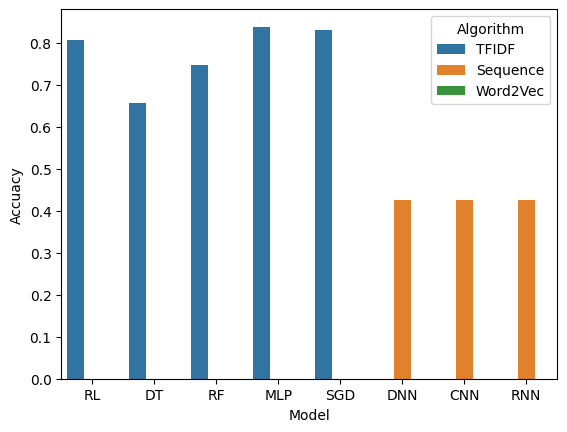

,RL,DT,RF,MLP,SGD,DNN,CNN,RNN
TFIDF,0.807554,0.656475,0.747302,0.839029,0.831835,NaN,NaN,NaN
Sequence,NaN,NaN,NaN,NaN,NaN,0.42536,0.42536,0.42536
Word2Vec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_matrix = pd.DataFrame.from_dict(results)
df_results = df_matrix.reset_index().rename(columns={"index": "Model"})
df_results = df_results.melt(id_vars=['Model'], value_vars=['TFIDF','Sequence','Word2Vec']).rename(columns={'variable': 'Algorithm', 'value':'Accuacy'})
sns.barplot(data=df_results, y='Accuacy', x='Model', hue='Algorithm')
plt.show()
df_matrix.T

## 5. Using pre-trained model(Optional)
* 한국어 pre-trained model로 fine tuning 및 성능 분석
> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
> * [HuggingFace-Korean](https://huggingface.co/models?language=korean)